Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Tradução Automática e o Conjunto de Dados
:label:`sec_machine_translation`

Usamos RNNs para projetar modelos de linguagem,
que são essenciais para o processamento de linguagem natural.
Outro benchmark emblemático é a *tradução automática*,
um domínio de problema central para modelos de *transdução de sequência*
que transformam sequências de entrada em sequências de saída.
Desempenhando um papel crucial em várias aplicações modernas de IA,
modelos de transdução de sequência formarão o foco do restante deste capítulo
e :numref:`chap_attention`.
Para este fim,
esta seção apresenta o problema da tradução automática
e seu conjunto de dados que será usado posteriormente.

*Tradução automática* refere-se ao
tradução automática de uma sequência
de um idioma para outro.
Na verdade, este campo
pode remontar a 1940
logo depois que os computadores digitais foram inventados,
especialmente considerando o uso de computadores
para decifrar códigos de linguagem na Segunda Guerra Mundial.
Por décadas,
abordagens estatísticas
tinha sido dominante neste campo :cite:`Brown.Cocke.Della-Pietra.ea.1988, Brown.Cocke.Della-Pietra.ea.1990`
antes da ascensão
de
aprendizagem ponta a ponta usando
redes neurais.
O último
é frequentemente chamado
*tradução automática neural*
para se distinguir de
*tradução automática de estatística*
que envolve análise estatística
em componentes como
o modelo de tradução e o modelo de linguagem.

Enfatizando o aprendizado de ponta a ponta,
este livro se concentrará em métodos de tradução automática neural.
Diferente do nosso problema de modelo de linguagem
in :numref:`sec_language_model`
cujo corpus está em um único idioma,
conjuntos de dados de tradução automática
são compostos por pares de sequências de texto
que estão em
o idioma de origem e o idioma de destino, respectivamente.
Desse modo,
em vez de reutilizar a rotina de pré-processamento
para modelagem de linguagem,
precisamos de uma maneira diferente de pré-processar
conjuntos de dados de tradução automática.
Na sequência,
nós mostramos como
carregar os dados pré-processados
em minibatches para treinamento.


In [1]:
import os
import torch
from d2l import torch as d2l

## Download e Pré-processamento do Conjunto de Dados

Começar com,
baixamos um conjunto de dados inglês-francês
que consiste em [pares de frases bilíngues do Projeto Tatoeba](http://www.manythings.org/anki/).
Cada linha no conjunto de dados
é um par delimitado por tabulação
de uma sequência de texto em inglês
e a sequência de texto traduzida em francês.
Observe que cada sequência de texto
pode ser apenas uma frase ou um parágrafo de várias frases.
Neste problema de tradução automática
onde o inglês é traduzido para o francês,
Inglês é o *idioma de origem*
e o francês é o *idioma de destino*.


In [2]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



Depois de baixar o conjunto de dados,
continuamos com várias etapas de pré-processamento
para os dados de texto brutos.
Por exemplo,
substituímos o espaço ininterrupto por espaço,
converter letras maiúsculas em minúsculas,
e insira espaço entre palavras e sinais de pontuação.


In [3]:
#@save
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## Tokenização

Diferente da tokenização em nível de personagem
in:numref:`sec_language_model`,
para tradução automática
preferimos tokenização em nível de palavra aqui
(modelos de última geração podem usar técnicas de tokenização mais avançadas).
A seguinte função `tokenize_nmt`
tokeniza os primeiros pares de sequência de texto `num_examples`,
Onde
cada token é uma palavra ou um sinal de pontuação.
Esta função retorna
duas listas de listas de tokens: `source` e` target`.
Especificamente,
`source [i]` é uma lista de tokens do
$i^\mathrm{th}$ sequência de texto no idioma de origem (inglês aqui) e `target [i]` é a do idioma de destino (francês aqui).


In [4]:
#@save
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

Deixe-nos representar graficamente o histograma do número de tokens por sequência de texto.
Neste conjunto de dados inglês-francês simples,
a maioria das sequências de texto tem menos de 20 tokens.


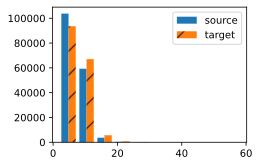

In [5]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

## Vocabulário

Uma vez que o conjunto de dados da tradução automática
consiste em pares de línguas,
podemos construir dois vocabulários para
tanto o idioma de origem quanto
o idioma de destino separadamente.
Com tokenização em nível de palavra,
o tamanho do vocabulário será significativamente maior
do que usando tokenização em nível de caractere.
Para aliviar isso,
aqui tratamos tokens infrequentes
que aparecem menos de 2 vezes
como o mesmo token desconhecido ("&lt;bos&gt;").
Além disso,
especificamos tokens especiais adicionais
como para sequências de preenchimento ("&lt;bos&gt;") com o mesmo comprimento em minibatches,
e para marcar o início ("&lt;bos&gt;") ou o fim ("&lt;bos&gt;") das sequências.
Esses tokens especiais são comumente usados em
tarefas de processamento de linguagem natural.


In [6]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

## Carregando o Conjunto de Dados
:label:`subsec_mt_data_loading`

Lembre-se de que na modelagem de linguagem
cada exemplo de sequência,
ou um segmento de uma frase
ou uma extensão de várias frases,
tem um comprimento fixo.
Isso foi especificado pelo `num_steps`
(número de etapas de tempo ou tokens) argumento em :numref:`sec_language_model`.
Na tradução automática, cada exemplo é
um par de sequências de texto de origem e destino,
onde cada sequência de texto pode ter comprimentos diferentes.

Para eficiência computacional,
ainda podemos processar um minibatch de sequências de texto
ao mesmo tempo por *truncamento* e *preenchimento*.
Suponha que cada sequência no mesmo minibatch
deve ter o mesmo comprimento `num_steps`.
Se uma sequência de texto tiver menos de tokens `num_steps`,
continuaremos acrescentando a seção especial "&lt;pad&gt;" símbolo
ao final até que seu comprimento alcance `num_steps`.
Por outro lado,
vamos truncar a sequência de texto
pegando apenas seus primeiros tokens `num_steps`
e descartando o restante.
Desta maneira,
cada sequência de texto
terá o mesmo comprimento
para ser carregado em minibatches do mesmo formato.

A seguinte função `truncate_pad`
trunca ou preenche sequências de texto conforme descrito anteriormente.


In [7]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

Agora definimos uma função para transformar
sequências de texto em minibatches para treinamento.
Anexamos o especial “&lt;eos&gt;” símbolo
ao final de cada sequência para indicar o
fim da sequência.
Quando um modelo está prevendo
de
gerar um token de sequência após o token,
a geração
do “&lt;eos&gt;” símbolo
pode sugerir que
a sequência de saída está completa.
Além do mais,
nós também gravamos o comprimento
de cada sequência de texto, excluindo os tokens de preenchimento.
Esta informação será necessária por
alguns modelos que
nós cobriremos mais tarde.


In [8]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

## Juntando todas as coisas

Finalmente, definimos a função `load_data_nmt`
para retornar o iterador de dados, junto com
os vocabulários do idioma de origem e do idioma de destino.


In [9]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

Vamos ler o primeiro minibatch do conjunto de dados inglês-francês.


In [10]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tensor([[  6,  18, 153,   4,   3,   1,   1,   1],
        [166,  15,   5,   3,   1,   1,   1,   1]], dtype=torch.int32)
valid lengths for X: tensor([5, 4])
Y: tensor([[  6,   7,  60,   4,   3,   1,   1,   1],
        [  0,  50, 174,   5,   3,   1,   1,   1]], dtype=torch.int32)
valid lengths for Y: tensor([5, 5])


## Sumário

* Tradução automática refere-se à tradução automática de uma sequência de um idioma para outro.
* Usando tokenização em nível de palavra, o tamanho do vocabulário será significativamente maior do que usando tokenização em nível de caractere. Para aliviar isso, podemos tratar tokens raros como o mesmo token desconhecido.
* Podemos truncar e preencher sequências de texto para que todas tenham o mesmo comprimento para serem carregadas em minibatches.

## Exercícios

1. Tente valores diferentes do argumento `num_examples` na função` load_data_nmt`. Como isso afeta os tamanhos do vocabulário do idioma de origem e do idioma de destino?
1. O texto em alguns idiomas, como chinês e japonês, não tem indicadores de limite de palavras (por exemplo, espaço). A tokenização em nível de palavra ainda é uma boa ideia para esses casos? Por que ou por que não?


[Discussions](https://discuss.d2l.ai/t/1060)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTE0NjI0MTk1OTEsNjQyMTc3MjQ0XX0=
-->
